# Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 44s 0us/step


In order to reference the class names of the images during the visualization stage, a python list containing the classes is initialized with the variable name CLASS_NAMES.

In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

TensorFlow provides a suite of functions and operations that enables easy data manipulation and modification through a defined input pipeline.

To be able to access these methods and procedures, it is required that we transform our dataset into an efficient data representation TensorFlow is familiar with. This is achieved using the **tf.data.Dataset API**.

More specifically, **tf.data.Dataset.from_tensor_slices** method takes the train, test, and validation dataset partitions and returns a corresponding TensorFlow Dataset representation.

In [4]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))


# Preprocessing

Usually, preprocessing is conducted to ensure the data utilized is within an appropriate format.

First, let’s visualize the images within the CIFAR-10 dataset.

The CIFAR-10 images have small dimensions, which makes visualization of the actual pictures a bit difficult.

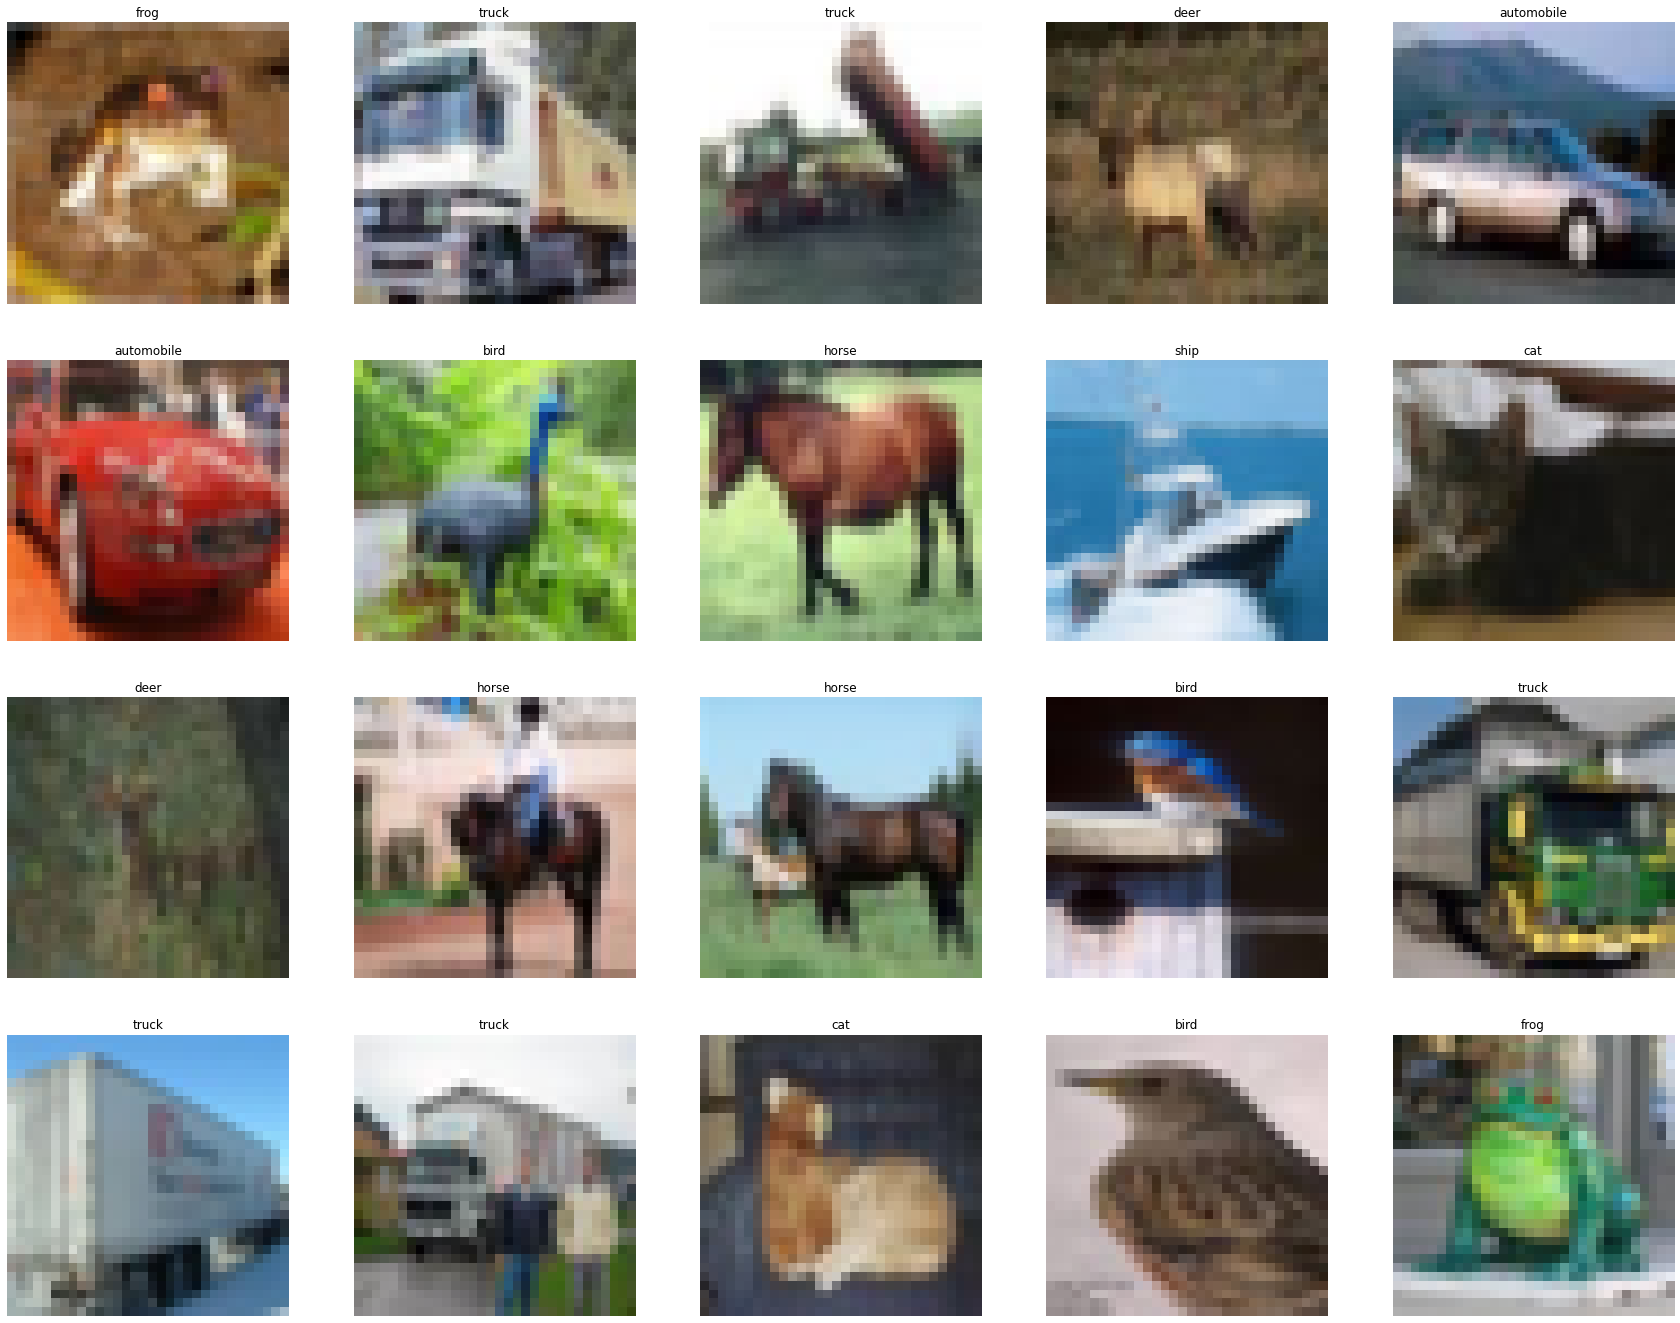

In [5]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

We’ll create a function called process_images.

This function will perform all preprocessing work that we require for the data. This function is called further down the machine learning workflow.

In [6]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

# Data Pipeline

So far, we have obtained and partitioned the dataset and created a function to process the dataset. The next step is to build an input pipeline.

An input/data pipeline is described as a series of functions or methods that are called consecutively one after another. 

Input pipelines are a chain of functions that either act upon the data or enforces an operation on the data flowing through the pipeline.


In [7]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)


Train size: 50000
Test size: 10000


### For our basic input/data pipeline, we will conduct three primary operations:
 
#### 1. Preprocessing the data within the dataset
#### 2. Shuffle the dataset
#### 3. Batch data within the dataset

In [8]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

In [9]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])

In [11]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         5

In [12]:
history=model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/50
1562/1562 [==============================] - 11s 7ms/step - loss: 2.1766 - accuracy: 0.2334 - val_loss: 1.7027 - val_accuracy: 0.3889
Epoch 2/50
1562/1562 [==============================] - 11s 7ms/step - loss: 1.8014 - accuracy: 0.3414 - val_loss: 1.5595 - val_accuracy: 0.4481
Epoch 3/50
1562/1562 [==============================] - 12s 7ms/step - loss: 1.6577 - accuracy: 0.3979 - val_loss: 1.4675 - val_accuracy: 0.4830
Epoch 4/50
1562/1562 [==============================] - 11s 7ms/step - loss: 1.5378 - accuracy: 0.4464 - val_loss: 1.3799 - val_accuracy: 0.5133
Epoch 5/50
1562/1562 [==============================] - 11s 7ms/step - loss: 1.4480 - accuracy: 0.4791 - val_loss: 1.3428 - val_accuracy: 0.5255
Epoch 6/50
1562/1562 [==============================] - 11s 7ms/step - loss: 1.3675 - accuracy: 0.5113 - val_loss: 1.2931 - val_accuracy: 0.5421
Epoch 7/50
1562/1562 [==============================] - 11s 7ms/step - loss: 1.2915 - accuracy: 0.5373 - val_loss: 1.2699 - val_ac

In [13]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Now we will visualize the training over the different epochs .

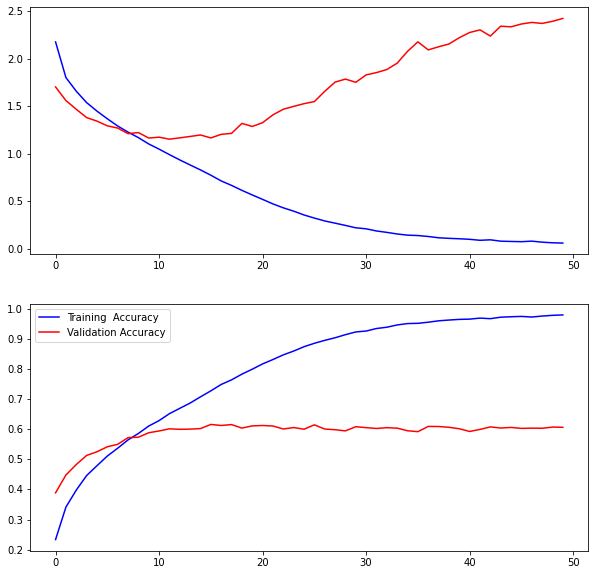

In [14]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [24]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.6163862347602844
